In [51]:
from pybaseball import schedule_and_record
from pandasql import sqldf
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)

REFRESH_DATA = 0 # set to 1 to pull new data, otherwise leave 0
DATA_DIR = "2024_mlb_team_game_logs"

First we define the list of MLB teams by three letter code on baseball-reference.com

In [52]:
mlb_teams = [
    "BAL", "BOS", "CHW", "CLE", "DET", "HOU", "KC", "LAA", "MIN", "NYY", "OAK", "SEA", "TBR", "TEX", "TOR",
    "ARI", "ATL", "CHC", "CIN", "COL", "MIA", "MIL", "NYM", "PHI", "PIT", "SDP", "SFG", "STL", "WSN"
]

Next, we pull down fresh data locally to work with but only if we set REFRESH_DATA to True.

In [53]:
if REFRESH_DATA == 1:
    for team in mlb_teams:
        data = schedule_and_record(2024, team)
        data.to_csv(f"{DATA_DIR}/{team}.csv", sep=',', encoding="utf-8")

After, we read the databack in and prepare to shape it for our analysis

In [54]:

path = f'{DATA_DIR}/' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

Drop all unceessary columns for our data application.

In [55]:
df = df.drop(columns=["Unnamed: 0", "GB", "Win", "Opp", "Loss", "RA", "Save", "W-L", "W/L", "D/N", "cLI", "Streak","Rank", "Inn", "Orig. Scheduled"])

Locate all the duplicate entries since this is the output for all teams.

In [56]:
duplicates = df[df.duplicated(subset=['Date', 'Attendance'])]

Now that we have our duplicate fields, we need to rename them and get them ready to merge back into `df`

In [57]:
all_data = pd.merge(df, duplicates, how="outer", on=["Attendance", "Date", "Time"])
all_data.shape

(5472, 9)

Perform cleanup actions on the newly merged data set.

In [58]:
all_data.drop(all_data.index[all_data['Tm_x'] == all_data['Tm_y']], inplace=True)
all_data = all_data.dropna(subset=["Attendance"])

all_data['Total_Runs'] = all_data['R_x'] + all_data['R_y']

all_data = all_data[['Date', 'Tm_x', 'Home_Away_x', 'R_x', 'Tm_y', 'Home_Away_y', 'R_y', 'Total_Runs', 'Time', 'Attendance']]
all_data = all_data.sort_values(by=['Date'])
all_data = all_data.reset_index(drop=True)

Now that's great, lets create some graphs

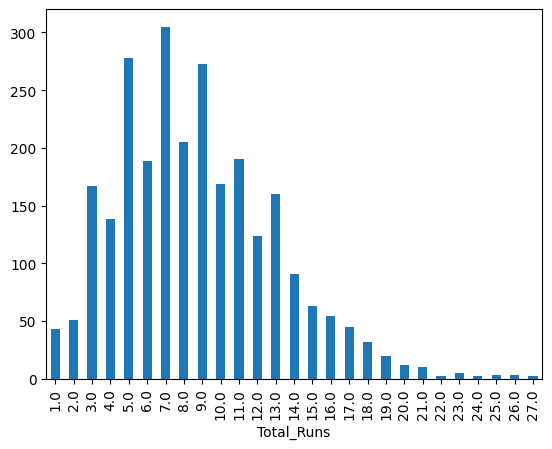

In [59]:

ax = all_data['Total_Runs'].value_counts()
ax = ax.sort_index()
ax = ax.plot(kind='bar')

At this point, we have enough data to determine what games have ended in each number of total runs. 

One potential way we could use this data is to prospect betting lines offing favorable over/under odds for the total runs market.

In [60]:

total_games = len(all_data.index)
max_runs = int(all_data['Total_Runs'].max())
min_runs = int(all_data['Total_Runs'].min())

for n in range(min_runs, max_runs):
    games = sqldf(f'''SELECT COUNT(*) from all_data WHERE Total_Runs <= {n}''').iloc[0,0]
    print(f"Percentage of games {n} runs or less: {((games/total_games)* 100):.2f}%")

for n in range(min_runs, max_runs):
    games = sqldf(f'''SELECT COUNT(*) from all_data WHERE Total_Runs >= {n}''').iloc[0,0]
    print(f"Percentage of games {n} runs or more: {((games/total_games)* 100):.2f}%")

Percentage of games 1 runs or less: 1.62%
Percentage of games 2 runs or less: 3.55%
Percentage of games 3 runs or less: 9.85%
Percentage of games 4 runs or less: 15.06%
Percentage of games 5 runs or less: 25.56%
Percentage of games 6 runs or less: 32.69%
Percentage of games 7 runs or less: 44.21%
Percentage of games 8 runs or less: 51.94%
Percentage of games 9 runs or less: 62.25%
Percentage of games 10 runs or less: 68.63%
Percentage of games 11 runs or less: 75.80%
Percentage of games 12 runs or less: 80.48%
Percentage of games 13 runs or less: 86.52%
Percentage of games 14 runs or less: 89.96%
Percentage of games 15 runs or less: 92.34%
Percentage of games 16 runs or less: 94.38%
Percentage of games 17 runs or less: 96.07%
Percentage of games 18 runs or less: 97.28%
Percentage of games 19 runs or less: 98.04%
Percentage of games 20 runs or less: 98.49%
Percentage of games 21 runs or less: 98.87%
Percentage of games 22 runs or less: 98.94%
Percentage of games 23 runs or less: 99.13%


The results should reveal a specific number of total runs in a game that we may opt to monitor sportsbooks for market innefficiencies. I.e for example, if 54% of games end in 8 runs or more we may look for lines that are offering +101 or more to gain a slight edge. Albit a small one. 

Next, we can model what it might look like if we hypothetically bet on every game at a random line between -101 and 101. Note: this is not a great way to model but it gets the point across. 



In [ ]:
odds_l = -102
odds_h = 102
stake = 1
bankroll = 500

# recall that total_games is defined above
for n in range(min_runs, max_runs):
    games = sqldf(f'''SELECT COUNT(*) from all_data WHERE Total_Runs <= {n}''').iloc[0,0]   
    print(f"Percentage of games {n} runs or less: {((games/total_games)* 100):.2f}%") 

    for x in range(1, games):
        rand_odds = random.randint(odds_l, odds_h)
        payout = (stake * rand_odds) / 100
        bankroll = bankroll + payout
    
    print(f"The resulting bankroll for odds between {odds_l}/{odds_h} and a stake of {stake} across {total_games} games: {bankroll:.2f}")  


for n in range(min_runs, max_runs):
    games = sqldf(f'''SELECT COUNT(*) from all_data WHERE Total_Runs >= {n}''').iloc[0,0]   
    print(f"Percentage of games {n} runs or more: {((games/total_games)* 100):.2f}%") 

    for x in range(1, games):
        rand_odds = random.randint(odds_l, odds_h)
        payout = (stake * rand_odds) / 100
        bankroll = bankroll + payout
    
    print(f"The resulting bankroll for odds between {odds_l}/{odds_h} and a stake of {stake} across {total_games} games: {bankroll:.2f}")  


Percentage of games 1 runs or less: 1.62%
The resulting bankroll for odds between -102/102 and a stake of 1 across 2649 games: 497.71
Percentage of games 2 runs or less: 3.55%
The resulting bankroll for odds between -102/102 and a stake of 1 across 2649 games: 495.08
Percentage of games 3 runs or less: 9.85%
The resulting bankroll for odds between -102/102 and a stake of 1 across 2649 games: 503.59
Percentage of games 4 runs or less: 15.06%
The resulting bankroll for odds between -102/102 and a stake of 1 across 2649 games: 509.36
Percentage of games 5 runs or less: 25.56%
The resulting bankroll for odds between -102/102 and a stake of 1 across 2649 games: 502.59
Percentage of games 6 runs or less: 32.69%
The resulting bankroll for odds between -102/102 and a stake of 1 across 2649 games: 492.01
Percentage of games 7 runs or less: 44.21%
The resulting bankroll for odds between -102/102 and a stake of 1 across 2649 games: 496.43
Percentage of games 8 runs or less: 51.94%
The resulting b

Write our results to CSV incase we want them later

In [ ]:
all_data.to_csv(f'{DATA_DIR}/all_data.csv', sep=',', encoding='utf-8')